# Preamble

In [1]:
# Imports
## General
import numpy as np
import pickle as pkl
import json
import warnings
warnings.filterwarnings('ignore')
import gc

## Data manipulation and preprocessing
import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler, FunctionTransformer,LabelEncoder, MinMaxScaler,OrdinalEncoder
#import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, MissingIndicator
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy import sparse
from tensorflow.keras.layers.experimental.preprocessing import StringLookup, Normalization

## Pre-processing functions
def criteo_log_transform(z):
    if z>2:
        return np.log(z)**2
    else:
        return z
def map_criteo_log_transform(x):
    return x.map(criteo_log_transform)

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

## Modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from fastFM import sgd
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger
import tensorflow as tf
from deepctr.models.fnn import FNN
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.models.pnn import PNN
from deepctr.models.wdl import WDL

# Introduction

As outlined in the Feasibility secition of my Milestone 3 submission, I have segmented the work over the next few weeks according to the following timeline

![](figures/timeline.png)

Below I proceed by structuring my response according to the following sections
- Model Specific Research
- Data exploration, preprocessing and environment setup
- Model Replication and Experimentation

# Model Specific Research

*__Fill out details from readings__*

On the basis of my reasearch and published results, I have chosen to investigate the following models:

__Shallow__
- Logistic Regression
- Factorization Machines

__Deep__
- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

# Data Exploration, Caching, Preprocessing pipeline

## Cache the datasets from S3

In [2]:
# Retrieve the kdd12 train file
kdd12_train_path = tf.keras.utils.get_file(
    fname="kdd12_training.csv", 
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/kdd12/train/training/training.txt",
    cache_dir="./data",
    cache_subdir="kdd12"
)

10598457344/10598454239 [==============================] - 106s 0us/step


In [28]:
# Retrieve the kdd12 test file
kdd12_test_path = tf.keras.utils.get_file(
    fname="kdd12_test.csv", 
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/kdd12/test/test.txt",
    cache_dir="./data",
    cache_subdir="kdd12"
)
print(kdd12_test_path)

1354121216/1354115448 [==============================] - 14s 0us/step
./data/kdd12/kdd12_test.csv


In [30]:
# Retrieve the Avazu train file
avazu_train_path = tf.keras.utils.get_file(
    fname="avazu_train.csv", 
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/avazu/train/train.csv",
    cache_dir="./data",
    cache_subdir="avazu"
)
print(avazu_train_path)

6311149568/6311147778 [==============================] - 63s 0us/step
./data/avazu/avazu_train.csv


In [31]:
# Retrieve the Avazu test file
avazu_test_path = tf.keras.utils.get_file(
    fname="avazu_test.csv", 
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/avazu/test/test.csv",
    cache_dir="./data",
    cache_subdir="avazu"
)
print(avazu_test_path)

705798144/705791442 [==============================] - 7s 0us/step
./data/avazu/avazu_test.csv


In [34]:
# Retrieve the Criteo train file
criteo_train_path = tf.keras.utils.get_file(
    fname="criteo_train.csv",
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/dac/train/train.txt",
    cache_dir="./data",
    cache_subdir="criteo"
)
print(criteo_train_path)

11147190272/11147184845 [==============================] - 113s 0us/step
./data/criteo/criteo_train.csv


In [35]:
# Retrieve the Criteo test file
criteo_test_path = tf.keras.utils.get_file(
    fname="criteo_test.csv",
    origin="https://mlds-final-project-bucket.s3.eu-west-2.amazonaws.com/dac/test/test.txt",
    cache_dir="./data",
    cache_subdir="criteo"
)
print(criteo_test_path)

1460248576/1460246311 [==============================] - 15s 0us/step
./data/criteo/criteo_test.csv


## Load them as tf.datasets

In [2]:
def list_files_in_folder(bucket_name, folder_name):
    out = []
    # Create a Boto3 client for S3
    s3_client = boto3.client('s3')
 
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)
 
 
    if 'Contents' in response:
    
        for obj in response['Contents']:
            out.append(obj['Key'])
        out = out[1:]
        return out
    else:
        print("Folder is empty.")

### KDD12

In [3]:
# get avazu file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'kdd12/train/train_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [4]:
# Load the kdd12_train dataset
kdd12_train = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

2024-08-03 10:50:45.916707: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-03 10:50:45.920268: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 10:50:45.929997: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# get avazu file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'kdd12/train/test_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [6]:
# Load the kdd12_train dataset
kdd12_val = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

### Avazu

In [7]:
# get avazu file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'avazu/train/train_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [8]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]
avazu_train = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [9]:
# get avazu file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'avazu/train/test_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [10]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]

# Load the Avazu train dataset
avazu_val = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [11]:
# Drop ID variable
def drop_id(features, label):
    out_features = features.copy()
    del out_features['id']
    return out_features, label

In [12]:
avazu_train = avazu_train.map(drop_id)
avazu_val = avazu_val.map(drop_id)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Criteo

In [13]:
# get criteo file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'dac/train/train_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [14]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_train = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

In [15]:
# get criteo file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'dac/train/test_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [16]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_val = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

I first perform an exploratory data analysis to show the type of preprocessing that needs to be made. In order to simplify the data processing requirements, I do this on the basis of $n=10000$ row samples of the data.

## Preprocessing

Below I construct the preprocessing pipeline for the tensorflow datasets on the basis of the exploration functions above. I proceed by:

- Enconding the sparse catecorically features using the Ordinal Encoders specified above.
- Standardizing the numerical features unsing the Scalers and Transformer specified above.
- Generating the feature columns, as specified in the [DeepCTR Quickstart Guide](https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html#step-3-generate-feature-columns)

In [17]:
## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'C1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'C14',
    'C15',
    'C16',
    'C17',
    'C18',
    'C19',
    'C20',
    'C21'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]
criteo_categorical_columns = [f'cat_{i}' for i in np.arange(1,27)]

### Categorical Variable Encoding

In [18]:
# Import categorical feature mappings and define stringloohup objects for each dataset
kdd12_stringlookups = {}
for field in kdd12_categorical_columns:
    df = pd.read_csv(f'./data/kdd12/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    kdd12_stringlookups.update({field:lookup})

avazu_stringlookups = {}
for field in avazu_categorical_columns:
    df = pd.read_csv(f'./data/avazu/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    avazu_stringlookups.update({field:lookup})

criteo_stringlookups = {}
for field in criteo_categorical_columns:
    df = pd.read_csv(f'./data/criteo/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    criteo_stringlookups.update({field:lookup})

In [19]:
# Define categorical encoding function
@tf.function
def kdd12_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in kdd12_categorical_columns:
        lookup = kdd12_stringlookups[f]
        out_features[f.lower()] = lookup(features[f.lower()])
    return out_features, label

@tf.function
def avazu_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in avazu_categorical_columns:
        lookup = avazu_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

@tf.function
def criteo_categorical_encoding(features,label):
    # Create copy of features
    out_features = features.copy()
    # Iteratively map the categorical feature columns using the corresponding Lookup layer
    for f in criteo_categorical_columns:
        lookup = criteo_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

In [20]:
# Apply mapping over each dataset

kdd12_train_encoded = kdd12_train.map(kdd12_categorical_encoding)
avazu_train_encoded = avazu_train.map(avazu_categorical_encoding)
criteo_train_encoded = criteo_train.map(criteo_categorical_encoding)

kdd12_val_encoded = kdd12_val.map(kdd12_categorical_encoding)
avazu_val_encoded = avazu_val.map(avazu_categorical_encoding)
criteo_val_encoded = criteo_val.map(criteo_categorical_encoding)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

### Numerical Variable Scaling

In [21]:
# Define numerical feature columns
kdd12_numerical_columns = [
    'Depth',
    'Position',
    'Impression'
]

avazu_numerical_columns = [
    'hour'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]

In [22]:
# Extract scaler dicts for all datasets
dist_stats = pd.read_csv('./data/kdd12/means_variances.csv')
kdd12_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    kdd12_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/avazu/means_variances.csv')
avazu_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    avazu_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/criteo/means_variances.csv')
criteo_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    criteo_scalers.update({field:scaler})

In [23]:
# Define scaler functions for all datasets

@tf.function
def kdd12_numerical_scaling(features,label):
    out_features = features.copy()
    for f in kdd12_numerical_columns:
        scaler = kdd12_scalers[f]
        out_features[f.lower()] = scaler(features[f.lower()])
    return out_features, label

@tf.function
def avazu_numerical_scaling(features,label):
    out_features = features.copy()
    for f in avazu_numerical_columns:
        scaler = avazu_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

@tf.function
def criteo_numerical_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        scaler = criteo_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

In [24]:
# Apply the numerical scaling to all datasets
kdd12_train_scaled = kdd12_train_encoded.map(kdd12_numerical_scaling)
avazu_train_scaled = avazu_train_encoded.map(avazu_numerical_scaling)
criteo_train_scaled = criteo_train_encoded.map(criteo_numerical_scaling)

kdd12_val_scaled = kdd12_val_encoded.map(kdd12_numerical_scaling)
avazu_val_scaled = avazu_val_encoded.map(avazu_numerical_scaling)
criteo_val_scaled = criteo_val_encoded.map(criteo_numerical_scaling)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [25]:
# Print the element specs
print('KDD12:')
print(kdd12_train_scaled.element_spec)
print()
print('Avazu:')
print(avazu_train_scaled.element_spec)
print()
print('Criteo:')
print(criteo_train_scaled.element_spec)

KDD12:
(OrderedDict([('impression', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), ('displayurl', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('adid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('advertiserid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('depth', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), ('position', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), ('keywordid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('titleid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('descriptionid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('queryid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('userid', TensorSpec(shape=(None,), dtype=tf.int64, name=None))]), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Avazu:
(OrderedDict([('hour', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), ('C1', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('banner

In [26]:
# Apply log transformation to criteo datase

@tf.function
def criteo_log_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        x = features[f]
        out_features[f] = tf.where(x>2,tf.math.square(tf.math.log(x)),x)
    return out_features, label

In [27]:
criteo_train_scaled = criteo_train_scaled.map(criteo_log_scaling)
criteo_val_scaled = criteo_val_scaled.map(criteo_log_scaling)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [29]:
# Define model inputs
kdd12_train_model_input = kdd12_train_scaled.batch(256).prefetch(tf.data.AUTOTUNE)
avazu_train_model_input = avazu_train_scaled.batch(256).prefetch(tf.data.AUTOTUNE)
criteo_train_model_input = criteo_train_scaled.take(10000).batch(256).prefetch(tf.data.AUTOTUNE)

kdd12_val_model_input = kdd12_val_scaled.batch(256).prefetch(tf.data.AUTOTUNE)
avazu_val_model_input = avazu_val_scaled.batch(256).prefetch(tf.data.AUTOTUNE)
criteo_val_model_input = criteo_val_scaled.batch(256).prefetch(tf.data.AUTOTUNE)

### Define Feature columns

In [30]:
## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat.lower(), vocabulary_size=len(kdd12_stringlookups[feat].get_vocabulary()), embedding_dim=4) for feat in kdd12_categorical_columns]\
+ [DenseFeat(feat.lower(),1) for feat in kdd12_numerical_columns]
avazu_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=len(avazu_stringlookups[feat].get_vocabulary()), embedding_dim=4) for feat in avazu_categorical_columns]\
+ [DenseFeat(feat,1) for feat in avazu_numerical_columns]
criteo_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=len(criteo_stringlookups[feat].get_vocabulary()), embedding_dim=4) for feat in criteo_categorical_columns]\
+ [DenseFeat(feat,1) for feat in criteo_numerical_columns]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns

avazu_dnn_feature_columns = avazu_fixlen_feature_columns
avazu_linear_feature_columns = avazu_fixlen_feature_columns

criteo_dnn_feature_columns = criteo_fixlen_feature_columns
criteo_linear_feature_columns = criteo_fixlen_feature_columns

# Model Replication and Experimentation

## Shallow Models

In order to attain representitive results from beyond the realm of deep learning, below I evaluate two of the most poplarly used shallow models for CTR prediction:

- Logistic regression
- Factorization machines

### Logistic Regression

In [3]:
%run -i scripts/modelling/fit_lr_models.py
%run -i scripts/modelling/score_lr_models.py
%run -i scripts/modelling/save_lr_models.py

KDD12:
Log loss: 0.162493229115702
ROC AUC: 0.69918173566772
Accuracy: 0.95825

Avazu:
Log loss: 0.41220123857803254
ROC AUC: 0.7187724509322894
Accuracy: 0.83205

Criteo:
Log loss: 0.4926044086201233
ROC AUC: 0.7461917357547045
Accuracy: 0.76775


### Factorization Machine

In [4]:
%run -i scripts/modelling/fit_fm_models.py
%run -i scripts/modelling/score_fm_models.py
%run -i scripts/modelling/save_fm_models.py

KDD12:
Log loss: 0.31685987446578695
ROC AUC: 0.5336269490760196
Accuracy: 0.95825

Avazu:
Log loss: 10.974548402513749
ROC AUC: 0.5212335152327499
Accuracy: 0.66185

Criteo:
Log loss: 26.85071959222282
ROC AUC: 0.5000335570469798
Accuracy: 0.25505


## Deep Models

As explained above, I will be exploring the following deep models:

- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

### Factorization-Machine Supported Neural Networks

In [31]:
# Compile the models
kdd12_fnn_model = FNN(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_fnn_model = FNN(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_fnn_model = FNN(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [32]:
# Define the AutoInt CSVLogger callbacks
kdd12_fnn_csvLogger = CSVLogger('logs/kdd12_fnn.csv')
avazu_fnn_csvLogger = CSVLogger('logs/avazu_fnn.csv')
criteo_fnn_csvLogger = CSVLogger('logs/criteo_fnn.csv')

In [33]:
# Fit the models
kdd12_fnn_history = kdd12_fnn_model.fit(kdd12_train_model_input, validation_data=kdd12_val_model_input, batch_size=256, epochs=10, callbacks=[kdd12_fnn_csvLogger])
avazu_fnn_history = avazu_fnn_model.fit(avazu_train_model_input, validation_data=avazu_val_model_input, batch_size=256, epochs=10, callbacks=[avazu_fnn_csvLogger])
criteo_fnn_history = criteo_fnn_model.fit(criteo_train_model_input, validation_data=criteo_val_model_input, batch_size=256, epochs=10, callbacks=[criteo_fnn_csvLogger])

2024-08-03 10:59:29.007915: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-03 10:59:29.031505: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
40/40 [==============================] - 33s 728ms/step - loss: 0.4513 - binary_crossentropy: 0.4513 - val_loss: 0.2215 - val_binary_crossentropy: 0.2214
Epoch 2/10
40/40 [==============================] - 28s 694ms/step - loss: 0.1962 - binary_crossentropy: 0.1961 - val_loss: 0.2108 - val_binary_crossentropy: 0.2106
Epoch 3/10
40/40 [==============================] - 28s 709ms/step - loss: 0.1411 - binary_crossentropy: 0.1408 - val_loss: 0.2225 - val_binary_crossentropy: 0.2218
Epoch 4/10
40/40 [==============================] - 28s 708ms/step - loss: 0.0465 - binary_crossentropy: 0.0458 - val_loss: 0.2852 - val_binary_crossentropy: 0.2843
Epoch 5/10
40/40 [==============================] - 28s 702ms/step - loss: -0.0236 - binary_crossentropy: -0.0245 - val_loss: 0.4224 - val_binary_crossentropy: 0.4215
Epoch 6/10
40/40 [==============================] - 28s 700ms/step - loss: -0.0747 - binary_crossentropy: -0.0755 - val_loss: 0.4074 - val_binary_crossentropy: 0.4065
Epoch 

In [34]:
# Save the models
kdd12_fnn_model.save('models/fnn/kdd12_fnn_model.keras')
avazu_fnn_model.save('models/fnn/avazu_fnn_model.keras')
criteo_fnn_model.save('models/fnn/criteo_fnn_model.keras')

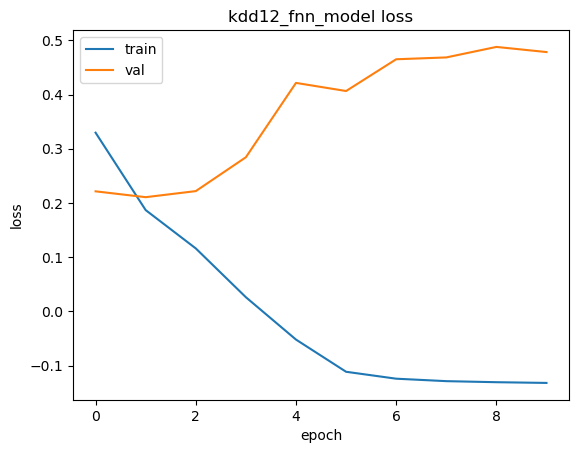

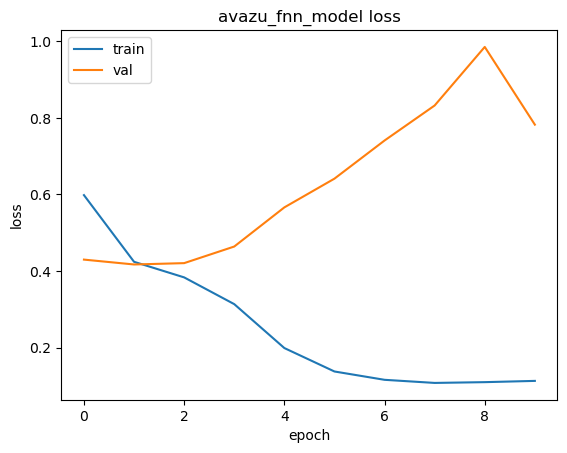

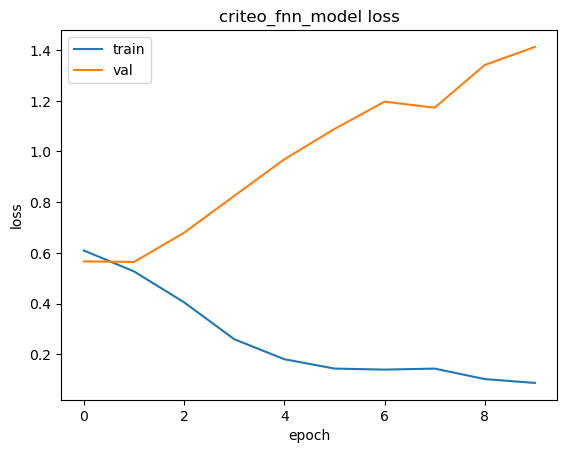

In [35]:
# Plot the training history
plt.plot(kdd12_fnn_history.history['binary_crossentropy'])
plt.plot(kdd12_fnn_history.history['val_binary_crossentropy'])
plt.title('kdd12_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_fnn_history.history['binary_crossentropy'])
plt.plot(avazu_fnn_history.history['val_binary_crossentropy'])
plt.title('avazu_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_fnn_history.history['binary_crossentropy'])
plt.plot(criteo_fnn_history.history['val_binary_crossentropy'])
plt.title('criteo_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
# Score the models
kdd12_fnn_score = kdd12_fnn_model.evaluate(kdd12_val_model_input, batch_size=256)
avazu_fnn_score = avazu_fnn_model.evaluate(avazu_val_model_input, batch_size=256)
criteo_fnn_score = criteo_fnn_model.evaluate(criteo_val_model_input, batch_size=256)

4/4 [==============================] - 7s 693ms/step - loss: 1.4138 - binary_crossentropy: 1.4125


### Product Based Neural Networks

In [142]:
# Compile the PNN models
kdd12_pnn_model = PNN(kdd12_dnn_feature_columns, task='binary')
kdd12_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_pnn_model = PNN(avazu_dnn_feature_columns, task='binary')
avazu_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_pnn_model = PNN(criteo_dnn_feature_columns, task='binary')
criteo_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [144]:
# Fit the models
kdd12_pnn_history = kdd12_pnn_model.fit(kdd12_train_model_input, batch_size=256, epochs=10, verbose=2, )
avazu_pnn_history = avazu_pnn_model.fit(avazu_train_model_input, batch_size=256, epochs=10, verbose=2, )
criteo_pnn_history = criteo_pnn_model.fit(criteo_train_model_input, batch_size=256, epochs=10, verbose=2, )

Epoch 1/10
40/40 - 20s - loss: 0.3242 - binary_crossentropy: 0.3242
Epoch 2/10
40/40 - 18s - loss: 0.2090 - binary_crossentropy: 0.2089
Epoch 3/10
40/40 - 19s - loss: 0.1573 - binary_crossentropy: 0.1570
Epoch 4/10
40/40 - 17s - loss: 0.0868 - binary_crossentropy: 0.0862
Epoch 5/10
40/40 - 17s - loss: 0.0478 - binary_crossentropy: 0.0471
Epoch 6/10
40/40 - 17s - loss: 0.0306 - binary_crossentropy: 0.0298
Epoch 7/10
40/40 - 17s - loss: 0.0165 - binary_crossentropy: 0.0158
Epoch 8/10
40/40 - 17s - loss: 0.0107 - binary_crossentropy: 0.0099
Epoch 9/10
40/40 - 17s - loss: 0.0019 - binary_crossentropy: 0.0011
Epoch 10/10
40/40 - 16s - loss: -3.8617e-03 - binary_crossentropy: -4.6531e-03


NameError: name 'avazu_train_y' is not defined

In [6]:
# Save the models
kdd12_pnn_model.save('models/pnn/kdd12_pnn_model.keras')
avazu_pnn_model.save('models/pnn/avazu_pnn_model.keras')
criteo_pnn_model.save('models/pnn/criteo_pnn_model.keras')

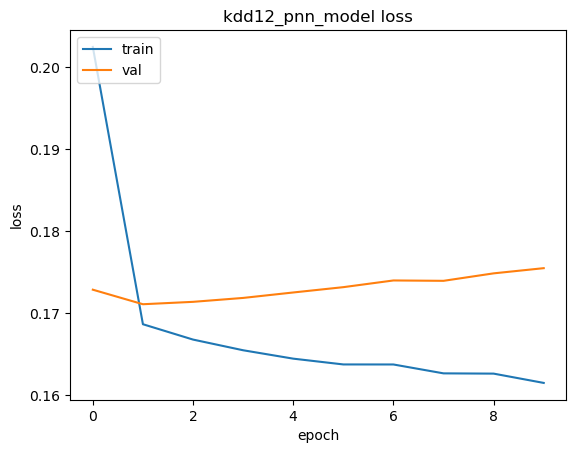

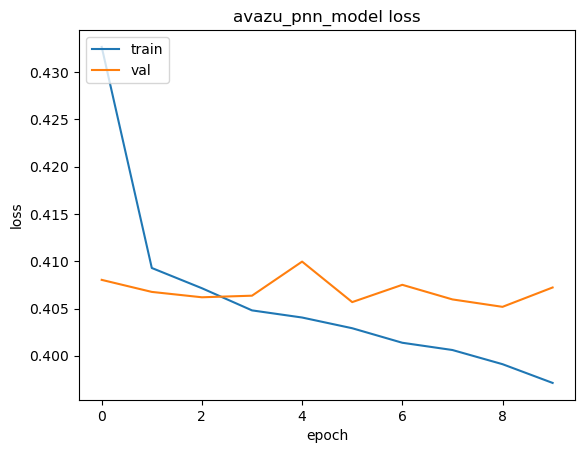

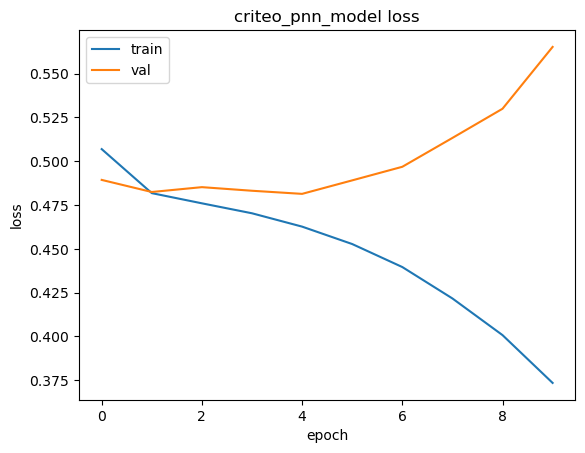

In [8]:
# Plot the training history
plt.plot(kdd12_pnn_history.history['binary_crossentropy'])
plt.plot(kdd12_pnn_history.history['val_binary_crossentropy'])
plt.title('kdd12_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_pnn_history.history['binary_crossentropy'])
plt.plot(avazu_pnn_history.history['val_binary_crossentropy'])
plt.title('avazu_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_pnn_history.history['binary_crossentropy'])
plt.plot(criteo_pnn_history.history['val_binary_crossentropy'])
plt.title('criteo_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Wide and Deep

In [3]:
# Compile the WDL models
kdd12_wdl_model = WDL(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_wdl_model = WDL(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_wdl_model = WDL(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

2024-07-16 19:58:52.079774: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-16 19:58:52.080443: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 19:58:52.083468: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [4]:
# Fit the Wide and Deep models
kdd12_wdl_history = kdd12_wdl_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
avazu_wdl_history = avazu_wdl_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
criteo_wdl_history = criteo_wdl_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

2024-07-16 20:01:08.717088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-16 20:01:08.717496: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 7s - loss: 0.2112 - binary_crossentropy: 0.2111 - val_loss: 0.1737 - val_binary_crossentropy: 0.1735
Epoch 2/10
250/250 - 4s - loss: 0.1692 - binary_crossentropy: 0.1689 - val_loss: 0.1715 - val_binary_crossentropy: 0.1711
Epoch 3/10
250/250 - 3s - loss: 0.1668 - binary_crossentropy: 0.1664 - val_loss: 0.1720 - val_binary_crossentropy: 0.1715
Epoch 4/10
250/250 - 4s - loss: 0.1656 - binary_crossentropy: 0.1650 - val_loss: 0.1740 - val_binary_crossentropy: 0.1734
Epoch 5/10
250/250 - 3s - loss: 0.1652 - binary_crossentropy: 0.1646 - val_loss: 0.1731 - val_binary_crossentropy: 0.1724
Epoch 6/10
250/250 - 3s - loss: 0.1643 - binary_crossentropy: 0.1636 - val_loss: 0.1749 - val_binary_crossentropy: 0.1743
Epoch 7/10
250/250 - 3s - loss: 0.1633 - binary_crossentropy: 0.1626 - val_loss: 0.1783 - val_binary_crossentropy: 0.1776
Epoch 8/10
250/250 - 3s - loss: 0.1625 - binary_crossentropy: 0.1618 - val_loss: 0.1750 - val_binary_crossentropy: 0.1743
Epoch 9/10
250/250 - 3s 

In [5]:
# Save the models
kdd12_wdl_model.save('models/wide_and_deep/kdd12_wdl_model.keras')
avazu_wdl_model.save('models/wide_and_deep/avazu_wdl_model.keras')
criteo_wdl_model.save('models/wide_and_deep/criteo_wdl_model.keras')

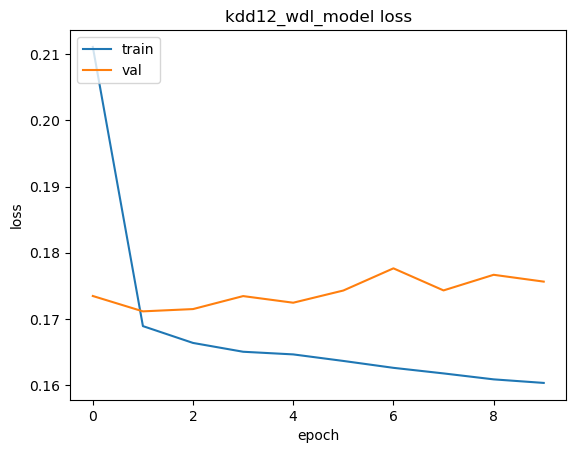

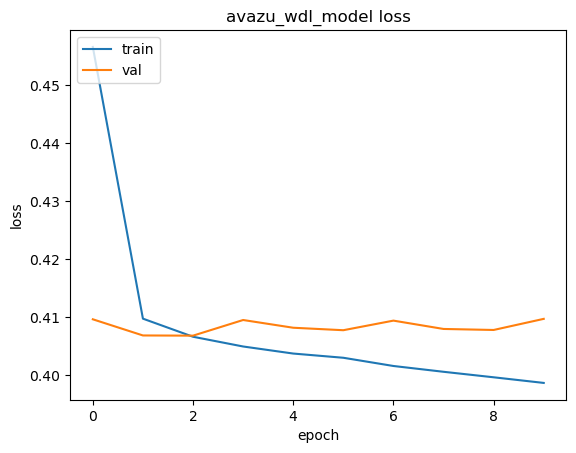

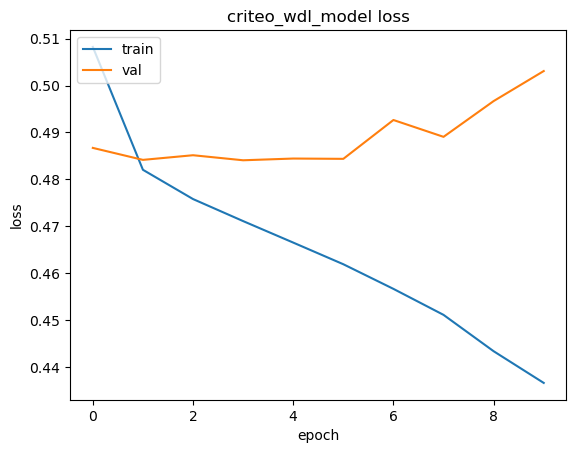

In [6]:
# Plot the training history
plt.plot(kdd12_wdl_history.history['binary_crossentropy'])
plt.plot(kdd12_wdl_history.history['val_binary_crossentropy'])
plt.title('kdd12_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_wdl_history.history['binary_crossentropy'])
plt.plot(avazu_wdl_history.history['val_binary_crossentropy'])
plt.title('avazu_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_wdl_history.history['binary_crossentropy'])
plt.plot(criteo_wdl_history.history['val_binary_crossentropy'])
plt.title('criteo_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### DeepFM

In [9]:
# Add this to the preamble
from deepctr.models.deepfm import DeepFM
from tensorflow.keras.callbacks import CSVLogger

In [4]:
# Compile the DeepFM models
kdd12_dfm_model = DeepFM(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_dfm_model = DeepFM(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_dfm_model = DeepFM(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

2024-07-23 17:38:36.663933: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-23 17:38:36.665190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 17:38:36.675451: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [6]:
# Define the CSVLogger callbacks
kdd12_dfm_csvLogger = CSVLogger('logs/kdd12_dfm.csv')
avazu_dfm_csvLogger = CSVLogger('logs/avazu_dfm.csv')
criteo_dfm_csvLogger = CSVLogger('logs/criteo_dfm.csv')

In [7]:
# Fit the DeepFM models
kdd12_dfm_history = kdd12_dfm_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[kdd12_dfm_csvLogger])
avazu_dfm_history = avazu_dfm_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[avazu_dfm_csvLogger])
criteo_dfm_history = criteo_dfm_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[criteo_dfm_csvLogger])

2024-07-23 17:49:05.132558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-23 17:49:05.142715: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 9s - loss: 0.2054 - binary_crossentropy: 0.2053 - val_loss: 0.1731 - val_binary_crossentropy: 0.1729
Epoch 2/10
250/250 - 4s - loss: 0.1696 - binary_crossentropy: 0.1693 - val_loss: 0.1712 - val_binary_crossentropy: 0.1709
Epoch 3/10
250/250 - 3s - loss: 0.1667 - binary_crossentropy: 0.1663 - val_loss: 0.1727 - val_binary_crossentropy: 0.1722
Epoch 4/10
250/250 - 4s - loss: 0.1660 - binary_crossentropy: 0.1655 - val_loss: 0.1741 - val_binary_crossentropy: 0.1735
Epoch 5/10
250/250 - 3s - loss: 0.1646 - binary_crossentropy: 0.1640 - val_loss: 0.1744 - val_binary_crossentropy: 0.1738
Epoch 6/10
250/250 - 3s - loss: 0.1637 - binary_crossentropy: 0.1630 - val_loss: 0.1739 - val_binary_crossentropy: 0.1733
Epoch 7/10
250/250 - 3s - loss: 0.1629 - binary_crossentropy: 0.1622 - val_loss: 0.1748 - val_binary_crossentropy: 0.1741
Epoch 8/10
250/250 - 4s - loss: 0.1622 - binary_crossentropy: 0.1615 - val_loss: 0.1747 - val_binary_crossentropy: 0.1740
Epoch 9/10
250/250 - 4s 

In [8]:
# Save the models
kdd12_dfm_model.save('models/deepfm/kdd12_dfm_model.keras')
avazu_dfm_model.save('models/deepfm/avazu_dfm_model.keras')
criteo_dfm_model.save('models/deepfm/criteo_dfm_model.keras')

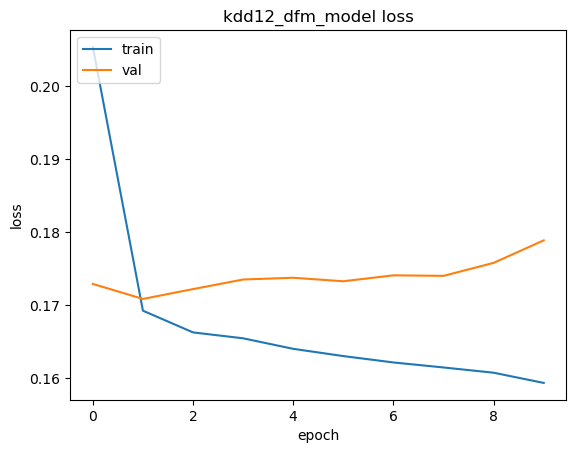

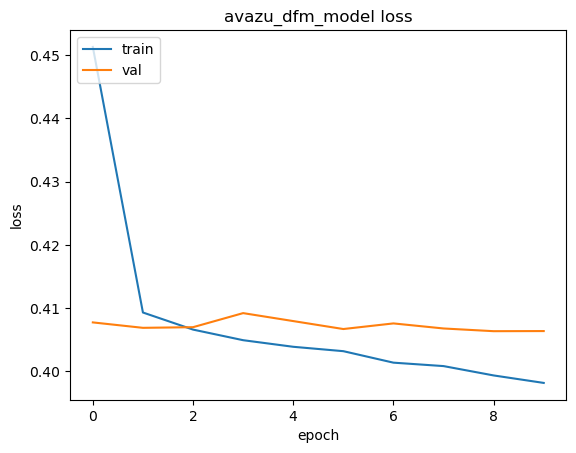

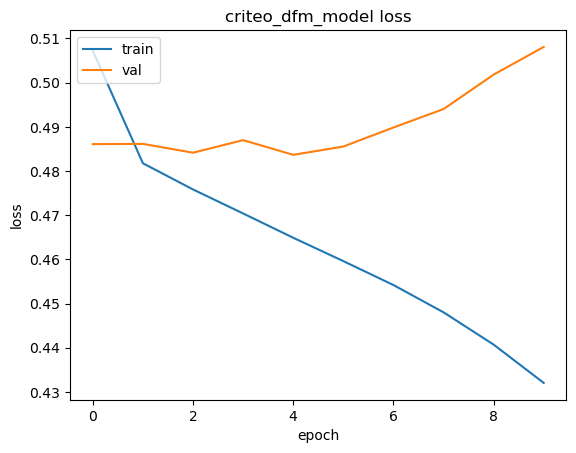

In [10]:
# Read in the history logs
kdd12_dfm_history = pd.read_csv('logs/kdd12_dfm.csv')
avazu_dfm_history = pd.read_csv('logs/avazu_dfm.csv')
criteo_dfm_history = pd.read_csv('logs/criteo_dfm.csv')

# Plot the training history
plt.plot(kdd12_dfm_history['binary_crossentropy'])
plt.plot(kdd12_dfm_history['val_binary_crossentropy'])
plt.title('kdd12_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_dfm_history['binary_crossentropy'])
plt.plot(avazu_dfm_history['val_binary_crossentropy'])
plt.title('avazu_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_dfm_history['binary_crossentropy'])
plt.plot(criteo_dfm_history['val_binary_crossentropy'])
plt.title('criteo_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Automatic Feature Interaction (AutoInt)

In [6]:
# Add this to the preamble
from deepctr.models.autoint import AutoInt

In [7]:
# Compile the AutoInt Models
kdd12_autoint_model = AutoInt(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_autoint_model = AutoInt(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_autoint_model = AutoInt(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
# Define the AutoInt CSVLogger callbacks
kdd12_autoint_csvLogger = CSVLogger('logs/kdd12_autoint.csv')
avazu_autoint_csvLogger = CSVLogger('logs/avazu_autoint.csv')
criteo_autoint_csvLogger = CSVLogger('logs/criteo_autoint.csv')

In [11]:
# Fit the AutoInt models
kdd12_autoint_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[kdd12_autoint_csvLogger])
avazu_autoint_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[avazu_autoint_csvLogger])
criteo_autoint_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, callbacks=[criteo_autoint_csvLogger])

2024-07-23 18:25:53.622273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-23 18:25:53.622615: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 13s - loss: 0.2118 - binary_crossentropy: 0.2117 - val_loss: 0.1741 - val_binary_crossentropy: 0.1740
Epoch 2/10
250/250 - 7s - loss: 0.1702 - binary_crossentropy: 0.1701 - val_loss: 0.1717 - val_binary_crossentropy: 0.1715
Epoch 3/10
250/250 - 7s - loss: 0.1666 - binary_crossentropy: 0.1665 - val_loss: 0.1723 - val_binary_crossentropy: 0.1721
Epoch 4/10
250/250 - 7s - loss: 0.1654 - binary_crossentropy: 0.1652 - val_loss: 0.1736 - val_binary_crossentropy: 0.1733
Epoch 5/10
250/250 - 6s - loss: 0.1643 - binary_crossentropy: 0.1641 - val_loss: 0.1738 - val_binary_crossentropy: 0.1736
Epoch 6/10
250/250 - 7s - loss: 0.1636 - binary_crossentropy: 0.1633 - val_loss: 0.1738 - val_binary_crossentropy: 0.1735
Epoch 7/10
250/250 - 7s - loss: 0.1631 - binary_crossentropy: 0.1628 - val_loss: 0.1759 - val_binary_crossentropy: 0.1756
Epoch 8/10
250/250 - 7s - loss: 0.1624 - binary_crossentropy: 0.1620 - val_loss: 0.1775 - val_binary_crossentropy: 0.1771
Epoch 9/10
250/250 - 7s

In [13]:
# Save the models
kdd12_autoint_model.save('models/autoint/kdd12_autoint_model.keras')
avazu_autoint_model.save('models/autoint/avazu_autoint_model.keras')
criteo_autoint_model.save('models/autoint/criteo_autoint_model.keras')

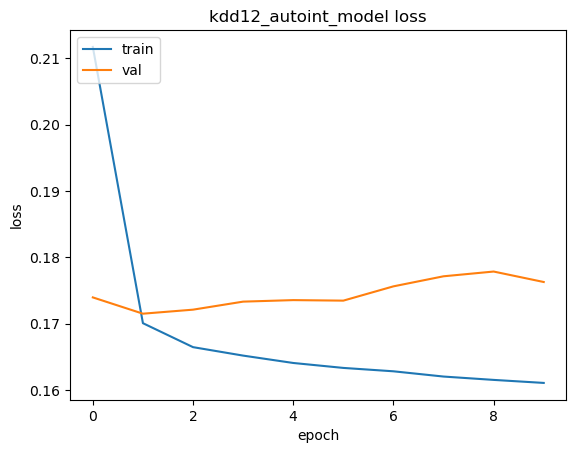

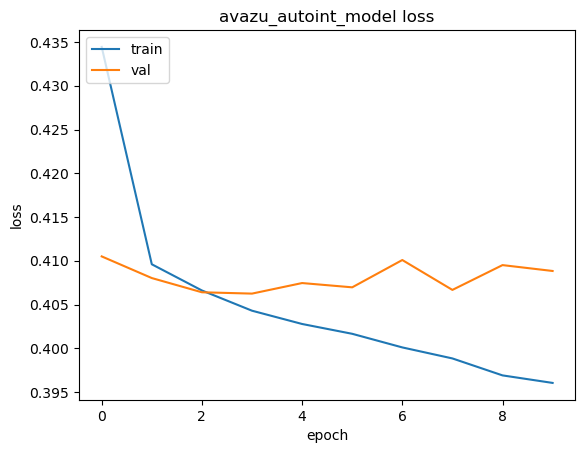

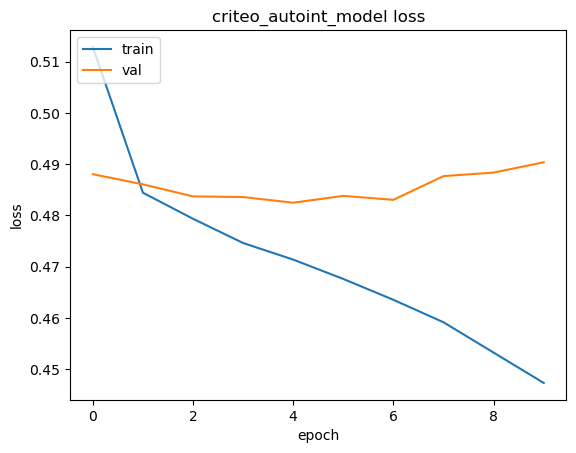

In [12]:
# Read in the history logs
kdd12_autoint_history = pd.read_csv('logs/kdd12_autoint.csv')
avazu_autoint_history = pd.read_csv('logs/avazu_autoint.csv')
criteo_autoint_history = pd.read_csv('logs/criteo_autoint.csv')

# Plot the training history
plt.plot(kdd12_autoint_history['binary_crossentropy'])
plt.plot(kdd12_autoint_history['val_binary_crossentropy'])
plt.title('kdd12_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_autoint_history['binary_crossentropy'])
plt.plot(avazu_autoint_history['val_binary_crossentropy'])
plt.title('avazu_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_autoint_history['binary_crossentropy'])
plt.plot(criteo_autoint_history['val_binary_crossentropy'])
plt.title('criteo_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Feature Generation by convolutional Neural Network - FGCNN

In [140]:
# Add the following to the preamble
from deepctr.models.fgcnn import FGCNN

In [151]:
# Compile the FGCNN models

#kdd12_fgcnn_model = FGCNN(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
#kdd12_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_fgcnn_model = FGCNN(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

#criteo_fgcnn_model = FGCNN(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
#criteo_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

In [147]:
gc.collect()

35401

In [148]:
avazu_fgcnn_model.fit(avazu_train_model_input, batch_size=256, epochs=10,)

Epoch 1/10
40/40 [==============================] - 72s 459ms/step - loss: 0.6546 - binary_crossentropy: 0.6546
Epoch 2/10
40/40 [==============================] - 19s 471ms/step - loss: 0.4159 - binary_crossentropy: 0.4159
Epoch 3/10
40/40 [==============================] - 19s 467ms/step - loss: 0.3581 - binary_crossentropy: 0.3579
Epoch 4/10
40/40 [==============================] - 20s 492ms/step - loss: 0.2485 - binary_crossentropy: 0.2481
Epoch 5/10
40/40 [==============================] - 20s 483ms/step - loss: 0.2091 - binary_crossentropy: 0.2087
Epoch 6/10
40/40 [==============================] - 20s 475ms/step - loss: 0.1921 - binary_crossentropy: 0.1916
Epoch 7/10
40/40 [==============================] - 20s 480ms/step - loss: 0.1932 - binary_crossentropy: 0.1926
Epoch 8/10
40/40 [==============================] - 20s 492ms/step - loss: 0.1906 - binary_crossentropy: 0.1899
Epoch 9/10
40/40 [==============================] - 20s 476ms/step - loss: 0.1684 - binary_crossentropy: